# ISSS610-Applied Machine Learning
## Business Problem
The data is originally from the article Hotel Booking Demand Datasets, written by Nuno Antonio, Ana Almeida, and Luis Nunes for Data in Brief, Volume 22, February 2019.

# Data Set
This dataset contains 119390 observations for a City Hotel and a Resort Hotel. Each observation represents a hotel booking between the 1st of July 2015 and 31st of August 2017, including booking that effectively arrived and booking that were canceled.

https://www.sciencedirect.com/science/article/pii/S2352340918315191

Done By 
- Anna Choo Xin Yi
- Filbert
- Wesley Djingga
- Xie Jianlong
- Zhang Jieyuan


In [38]:
#Import all here
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import dill as pickle
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,classification_report,log_loss
from tensorflow import keras
import warnings
import random
warnings.filterwarnings("ignore")


## Data Retrival

In [39]:
x_under_train,x_under_test,y_under_train,y_under_test,x_train,x_test,y_train,y_test = pickle.load(open("2.out.x_y_train_test", 'rb'))

## Model Retrival

In [40]:
forest = pickle.load(open('3a.out.forest', 'rb'))
knn = pickle.load(open('3b.out.knn', 'rb'))
log = pickle.load(open('3c.out.log', 'rb'))
nn = keras.models.load_model('3d-out-nn')
nb = pickle.load(open('3e.out.mnb', 'rb'))

# gnb = pickle.load(open('.\Naive Bayes\GNB.sav', 'rb'))
# mnb = pickle.load(open('.\Naive Bayes\MNB.sav', 'rb'))
# comnb = pickle.load(open('.\Naive Bayes\COMNB.sav', 'rb'))
# gnb_num = pickle.load(open('.\Naive Bayes\GNB_NUM.sav', 'rb'))
# catnb = pickle.load(open('.\Naive Bayes\CATNB.sav', 'rb'))

## Transform Retrival

In [41]:
enc = pickle.load(open('3a.out.enc', 'rb'))
forest_transform = pickle.load(open('3a.out.forest_transform', 'rb'))
scaler = pickle.load(open('3b.out.scaler', 'rb'))
knn_transform = pickle.load(open('3b.out.knn_transform', 'rb'))
log_transform = pickle.load(open('3c.out.log_transform', 'rb'))
nn_transform = pickle.load(open('3d.out.nn_transform', 'rb'))
nb_transform2 = pickle.load(open('3e.out.nb_transform', 'rb'))
nb_scale_transform = pickle.load(open('3e.out.nb_scale_transform', 'rb'))


In [42]:
#1m 32s
# prepare models
models = []
models.append(('Random Forest', forest,forest_transform))
models.append(('K Nearest Neighbor', knn,knn_transform))
models.append(('Logistic Regression', log,log_transform))
models.append(('Neutral Network', nn,nn_transform))
models.append(('Multinomial NB', nb,nb_scale_transform))

# evaluate each model in turn
accuracies = []
precisions = []
recalls = []
f1s = []
loglosses = []
names = []
for name, model,transform in models:

	y_pred = model.predict(transform(x_test)) 
	if name == 'Neutral Network':
		y_pred = y_pred > 0.5
	print(name)
	print(confusion_matrix(y_test, y_pred))
	print(" ")
	accuracies.append(round(accuracy_score(y_test, y_pred),6))
	precisions.append(round(precision_score(y_test, y_pred),6))
	recalls.append(round(recall_score(y_test, y_pred),6))
	f1s.append(round(f1_score(y_test, y_pred),6))
	loglosses.append(round(log_loss(y_test, y_pred),6))
	names.append(name)
# boxplot algorithm comparison
d = {'Models': names, 'Accuracy': accuracies, 'Precisions': precisions, 'Recalls': recalls, 'F1': f1s, 'Log Loss': loglosses}
df = pd.DataFrame(data=d).sort_values(by='F1', ascending=False)
df.set_index(['Models'])

Random Forest
[[13021  1390]
 [ 2539  6160]]
 
K Nearest Neighbor
[[12762  1649]
 [ 2301  6398]]
 
Logistic Regression
[[12985  1426]
 [ 2755  5944]]
 
Neutral Network
[[13231  1180]
 [ 1946  6753]]
 
Multinomial NB
[[12944  1467]
 [ 4289  4410]]
 


,Accuracy,Precisions,Recalls,F1,Log Loss
Models,,,,,
Neutral Network,0.864734,0.851254,0.776296,0.812049,4.671967
K Nearest Neighbor,0.829078,0.795079,0.735487,0.764123,5.903483
Random Forest,0.829987,0.815894,0.708127,0.758201,5.872088
Logistic Regression,0.819083,0.806513,0.683297,0.739810,6.248713
Multinomial NB,0.750930,0.750383,0.506955,0.605104,8.602612


# Ensemble

In [43]:
results = []
for name, model,transform in models:

	y_pred = model.predict(transform(x_test)) 
	if name == 'Neutral Network':
		y_pred = y_pred > 0.5
	results.append(y_pred)
results.append(y_test)

In [44]:
resultDF = pd.DataFrame(results).transpose()
resultDF.replace({False: 0, True: 1}, inplace=True)
resultDF.set_axis(['Random Forest', 'K Nearest Neighbor', 'Logistic Regression', 'Neutral Network', 'Multinomial NB','Y'], axis=1, inplace=True)
resultDF

,Random Forest,K Nearest Neighbor,Logistic Regression,Neutral Network,Multinomial NB,Y
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,1,1,1,1,1,1
4,0,0,0,1,0,0
...,...,...,...,...,...,...
23105,0,0,0,0,0,0
23106,1,1,1,1,1,1
23107,1,0,0,1,0,1
23108,1,1,1,1,1,1


In [45]:
resultDF["Vote"] = np.where((resultDF['Random Forest'] + resultDF['Multinomial NB'] + resultDF['K Nearest Neighbor'] + resultDF['Logistic Regression'] + resultDF['Neutral Network']) > 2, 1, 0)
#resultDF["Vote"] = np.where(resultDF['Neutral Network'] > 0, 1, 0)
resultDF
print("F1 Score:", f1_score(resultDF['Y'], resultDF['Vote']))
print("Precision Score:" , precision_score(resultDF['Y'], resultDF['Vote']))
print("Recall Score:" , recall_score(resultDF['Y'], resultDF['Vote']))
print("Classification Report\n",classification_report(resultDF['Y'], resultDF['Vote']))

F1 Score: 0.7825697466086512
Precision Score: 0.8825227305527493
Recall Score: 0.7029543625704104
Classification Report
               precision    recall  f1-score   support

           0       0.84      0.94      0.89     14411
           1       0.88      0.70      0.78      8699

    accuracy                           0.85     23110
   macro avg       0.86      0.82      0.84     23110
weighted avg       0.86      0.85      0.85     23110



## Finding Error Corelation

In [58]:
col = ['Random Forest', 'K Nearest Neighbor', 'Logistic Regression', 'Neutral Network', 'Multinomial NB']

err_rf=pd.DataFrame(abs(resultDF['Random Forest']- resultDF['Y']))
err_knn=pd.DataFrame(abs(resultDF['K Nearest Neighbor']- resultDF['Y']))
err_lr=pd.DataFrame(abs(resultDF['Logistic Regression']- resultDF['Y']))
err_nn=pd.DataFrame(abs(resultDF['Neutral Network']- resultDF['Y']))
err_mnb=pd.DataFrame(abs(resultDF['Multinomial NB']- resultDF['Y']))

final_err=np.concatenate((err_rf,err_knn,err_lr,err_nn, err_mnb), axis=1)
final_err_df = pd.DataFrame(final_err, columns = col)


In [64]:
final_err_df["total"] = final_err_df["Random Forest"]+final_err_df["K Nearest Neighbor"]+final_err_df["Logistic Regression"]+final_err_df["Neutral Network"]+final_err_df["Multinomial NB"]
final_err_df = final_err_df[final_err_df["total"]  > 0].drop("total",axis=1)

In [65]:
final_err_df

,Random Forest,K Nearest Neighbor,Logistic Regression,Neutral Network,Multinomial NB
4,0,0,0,1,0
8,0,0,0,0,1
10,0,0,0,1,0
12,0,0,1,0,0
16,0,0,0,0,1
...,...,...,...,...,...
23095,0,0,0,0,1
23100,1,1,1,0,1
23101,0,0,0,0,1
23102,1,0,1,0,1


<AxesSubplot:>

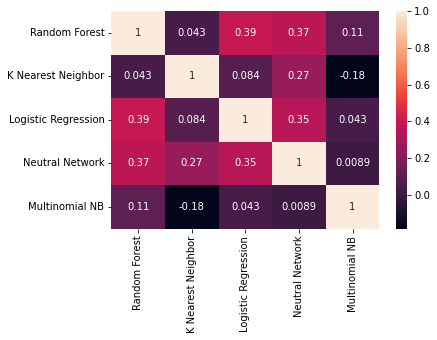

In [66]:
import seaborn as sns
sns.heatmap(final_err_df.corr(), annot=True)

In [88]:
# After dropping Multinomial NB
resultDF["Vote"] = np.where((resultDF['Random Forest'] + resultDF['K Nearest Neighbor'] + resultDF['Logistic Regression'] + resultDF['Neutral Network']+ resultDF['Multinomial NB']) > 1, 1, 0)
#resultDF["Vote"] = np.where(resultDF['Neutral Network'] > 0, 1, 0)
resultDF
print("F1 Score:", f1_score(resultDF['Y'], resultDF['Vote']))
print("Precision Score:" , precision_score(resultDF['Y'], resultDF['Vote']))
print("Recall Score:" , recall_score(resultDF['Y'], resultDF['Vote']))
print("Classification Report\n",classification_report(resultDF['Y'], resultDF['Vote']))

F1 Score: 0.742077035592394
Precision Score: 0.7017418032786885
Recall Score: 0.7873318772272675
Classification Report
               precision    recall  f1-score   support

           0       0.86      0.80      0.83     14411
           1       0.70      0.79      0.74      8699

    accuracy                           0.79     23110
   macro avg       0.78      0.79      0.79     23110
weighted avg       0.80      0.79      0.80     23110



## Simulation

We try running, simulation, to see with our NN predictor, we aim to minimize overloading and minimize wastage of our room

In [49]:
data = pd.concat([x_test, y_test], axis=1)

overLoadList = []
emptyRoomList = []
machineOverloadList = []
machineEmptyRoomList = []

for simulate in range(500):
    ran = random.randint(550, 650)
    data = pd.concat([x_test,y_test], axis=1)
    data = pd.concat([data[data['IsCanceled']==1].sample(n=1000-ran), data[data['IsCanceled']==0].sample(ran)])
    numberOfRoom = 100
    overloadPercentage = 0.4 #gut feeling
    overload = int(numberOfRoom * (1+overloadPercentage)) # the number of booking you allow to book
    inflow = data.sample(n=300)
    gutFeelingCustomerList = inflow.head(overload)
    actualCancel = sum(gutFeelingCustomerList["IsCanceled"].tolist())
    actualCame = overload-actualCancel
    actualNumberOfOverload = max((actualCame-numberOfRoom),0)
  
    ## Machine Learning
    predictY_nn = [x[0] for x in list(np.where(nn.predict(nn_transform(inflow))>0.5,1,0))]
    machineOverload = 0
    while (machineOverload-sum(predictY_nn[0:machineOverload]))<numberOfRoom:
        machineOverload = machineOverload + 1

    machineActualCancel = sum(inflow["IsCanceled"].tolist()[0:machineOverload])
    machineActualCame = machineOverload-machineActualCancel
    machineActualNumberOfOverload = max((machineActualCame-numberOfRoom),0)
 
    overLoadList.append(actualNumberOfOverload)
    emptyRoomList.append(max(numberOfRoom-actualCame, 0))
    machineOverloadList.append(machineActualNumberOfOverload)
    machineEmptyRoomList.append(max(numberOfRoom-machineActualCame, 0))
    
print("Machine Overload: ", sum(machineOverloadList) / len(machineOverloadList))
print("Machine Empty Room: ", sum(machineEmptyRoomList) / len(machineEmptyRoomList))

print("Gut Feeling Overload:",sum(overLoadList) / len(overLoadList))
print("Gut Feeling Empty Room:",sum(emptyRoomList) / len(emptyRoomList))

Machine Overload:  0.228
Machine Empty Room:  6.306
Gut Feeling Overload: 0.0
Gut Feeling Empty Room: 16.268
